In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from datetime import datetime
from datetime import timedelta

In [2]:
def get_dataset(url, country, state, recent_days_count):
    raw_dataset = pd.read_csv(url)
    df = raw_dataset[(raw_dataset['Country/Region']==country) & (raw_dataset['Province/State']==state)]
    df = df.drop(columns=['Lat', 'Long'])
    df1 = df.melt(['Province/State', 'Country/Region'], var_name='Date', value_name='Cases')
    df1.insert(3, 'Day', range(1, 1 + len(df1)))
    dataset_all = df1.drop(columns=['Province/State', 'Country/Region'])    
    dataset = dataset_all.tail(recent_days_count)
    return dataset

In [3]:
def get_model(dataset):
    X = dataset['Day'].values.reshape(-1,1)
    y = dataset['Cases'].values.reshape(-1,1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    regressor = LinearRegression()
    regressor.fit(X_train, y_train) #training the algorithm    
    y_pred = regressor.predict(X_test)
#     print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
#     print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
#     print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
#     plot_training_data(X_train, y_train, regressor).show()
#     plot_test_data(X_test, y_test, y_pred).show()
    return regressor


In [4]:
def plot_training_data(X_train, y_train, regressor):
    y_train_pred = regressor.predict(X_train)
    plt.scatter(X_train, y_train,  color='gray')
    plt.plot(X_train, y_train_pred, color='red', linewidth=2)
    return plt

In [5]:
def plot_test_data(X_test, y_test, y_pred):
    plt.scatter(X_test, y_test,  color='gray')
    plt.plot(X_test, y_pred, color='brown', linewidth=2)
    return plt

In [6]:
def get_next_days(dataset, prediction_duration):
    next_days = []
    next_days.append(dataset.tail(1)['Day'].values[0] + 1)
    for i in range(1, prediction_duration):
        next_days.append(next_days[-1] + 1)
    return next_days   


In [7]:
def get_next_dates(dataset, prediction_duration):
    next_dates = []
    next_dates.append(datetime.strftime(datetime.strptime(dataset.tail(1)['Date'].values[0] , '%m/%d/%y') + timedelta(days=1), '%m/%d/%Y'))
    for i in range(1, prediction_duration):
        next_dates.append(datetime.strftime(datetime.strptime(next_dates[-1], '%m/%d/%Y') + timedelta(days=1), '%m/%d/%Y'))
    return next_dates

In [8]:
def get_next_day_predictions(next_days, regressor):
    next_day_predictions = []
    for i in range(0, len(next_days)):
        next_day_predictions.append(int(regressor.predict([[next_days[i]]])[0,0]))
    return next_day_predictions


In [9]:
def perform_predictions(url, country, state, recent_days_count, prediction_duration):
    dataset = get_dataset(url, country, state, recent_days_count)
    regressor = get_model(dataset)
    next_days = get_next_days(dataset, prediction_duration)
    next_dates = get_next_dates(dataset, prediction_duration)
    next_day_predictions = get_next_day_predictions(next_days, regressor)
    return next_dates, next_day_predictions


In [10]:
def result_dataframe(country, state, next_dates, confirmed_cases_predictions, death_cases_predictions):
    d = {
        'Country': country, 
        'State': state, 
        'Date': next_dates, 
        'Confirmed_Cases_Predications': confirmed_cases_predictions,
        'Death_Cases_Predications': death_cases_predictions 
    }

    df = pd.DataFrame(d)
    df.style.set_properties(**{'text-align': 'left'})
    return df

In [11]:
confirmed_case_url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
death_case_url="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

In [102]:
## Prediction Model for Canada - Ontario
country="Canada"
state="Ontario"

confirmed_recent_days=9
death_recent_days_count=5
prediction_duration=10

confirmed_cases_next_dates, confirmed_cases_predictions = perform_predictions(confirmed_case_url, country, state, confirmed_recent_days, prediction_duration)

death_cases_next_dates, death_cases_predictions = perform_predictions(death_case_url, country, state, death_recent_days_count, prediction_duration)

result_dataframe(country, state, confirmed_cases_next_dates, confirmed_cases_predictions, death_cases_predictions)


,Country,State,Date,Confirmed_Cases_Predications,Death_Cases_Predications
0,Canada,Ontario,04/26/2020,15760,971
1,Canada,Ontario,04/27/2020,16351,1026
2,Canada,Ontario,04/28/2020,16942,1080
3,Canada,Ontario,04/29/2020,17533,1134
4,Canada,Ontario,04/30/2020,18124,1189
5,Canada,Ontario,05/01/2020,18716,1243
6,Canada,Ontario,05/02/2020,19307,1298
7,Canada,Ontario,05/03/2020,19898,1352
8,Canada,Ontario,05/04/2020,20489,1406
9,Canada,Ontario,05/05/2020,21080,1461


In [ ]:
## ARIMA to predict the peak count for Ontario

In [150]:
df = get_dataset(confirmed_case_url, country, state, 20).reset_index(drop=True) 
for i in range(0, len(df)):
    df.loc[i, 'Diff'] = 0 if i == 0 else df.loc[i, 'Cases'] - df.loc[i-1, 'Cases']
    df.loc[i, 'Spread_Rate'] = None if i == 0 else df.loc[i, 'Cases'] / df.loc[i-1, 'Cases']

df = df.tail(19)

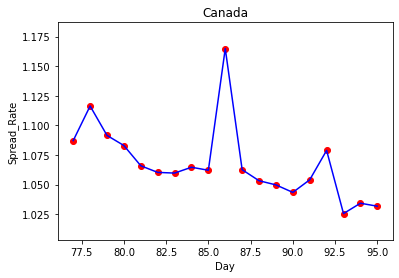

In [151]:
x=df.Day.values
y=df.Spread_Rate.values
plt.scatter(x, y, color='red')
plt.plot(x, y, color='blue')
plt.title('Canada')
plt.xlabel('Day')
plt.ylabel('Spread_Rate')
plt.show()

In [152]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%y')
ts_df = df[['Date', 'Spread_Rate']].set_index('Date')
ts_df

,Spread_Rate
Date,
2020-04-07,1.087187
2020-04-08,1.116377
2020-04-09,1.091547
2020-04-10,1.083001
2020-04-11,1.065897
2020-04-12,1.060319
2020-04-13,1.059725
2020-04-14,1.064659
2020-04-15,1.062115


In [153]:
def get_arima_order(train):
    p=d=q=range(0,5)
    pdq = list(itertools.product(p,d,q))
    import warnings
    warnings.filterwarnings('ignore')
    d={}
    for param in pdq:
        try:
            model_arima = ARIMA(train,order=param)
            model_arima_fit = model_arima.fit()
            d[param]=model_arima_fit.aic
        except:
            continue
    return min(d, key=lambda k: d[k]);

In [154]:
from statsmodels.tsa.arima_model import ARIMA
import itertools
X = ts_df.values
order = get_arima_order(X)
model_arima = ARIMA(X,order)
model_arima_fit = model_arima.fit()
predictions = model_arima_fit.forecast(200)[0]

In [149]:
order

array([103.63020772, 103.31059858, 102.99098943, 102.67138029,
       102.35177114, 102.032162  , 101.71255285, 101.39294371,
       101.07333457, 100.75372542, 100.43411628, 100.11450713,
        99.79489799,  99.47528884,  99.1556797 ,  98.83607056,
        98.51646141,  98.19685227,  97.87724312,  97.55763398,
        97.23802483,  96.91841569,  96.59880655,  96.2791974 ,
        95.95958826,  95.63997911,  95.32036997,  95.00076082,
        94.68115168,  94.36154254,  94.04193339,  93.72232425,
        93.4027151 ,  93.08310596,  92.76349681,  92.44388767,
        92.12427853,  91.80466938,  91.48506024,  91.16545109,
        90.84584195,  90.5262328 ,  90.20662366,  89.88701452,
        89.56740537,  89.24779623,  88.92818708,  88.60857794,
        88.28896879,  87.96935965,  87.64975051,  87.33014136,
        87.01053222,  86.69092307,  86.37131393,  86.05170478,
        85.73209564,  85.4124865 ,  85.09287735,  84.77326821,
        84.45365906,  84.13404992,  83.81444077,  83.49

In [143]:
df_new = df.tail(1).reset_index(drop=True)
df_new.loc[0, 'Day'] = 0
df_new['Date'] = df_new['Date'].astype(str) 
for i in range(0, len(predictions)):
    day =  df_new.Day[-1:].values[0] + 1
    diff = predictions[i]
    cases = (df_new.Cases[-1:].values[0] + diff)
    dateString = pd.to_datetime(str(df_new.Date[-1:].values[0])).strftime('%Y-%m-%d')
    date = datetime.strftime(datetime.strptime(dateString, '%Y-%m-%d') + timedelta(days=1), '%Y-%m-%d')
    df_new = df_new.append({'Date' : date, 'Day': day, 'Cases': cases, 'Diff': diff} , ignore_index=True)
    df_new['Cases'] = df_new['Cases'].astype(int)  
    df_new['Diff'] = df_new['Diff'].astype(int) 


In [144]:
df_new.head(50)

,Date,Day,Cases,Diff,Spread_Rate
0,2020-04-25,0,15012,462,103.175258
1,2020-04-26,1,15115,103,NaN
2,2020-04-27,2,15218,103,NaN
3,2020-04-28,3,15320,102,NaN
4,2020-04-29,4,15422,102,NaN
5,2020-04-30,5,15524,102,NaN
6,2020-05-01,6,15626,102,NaN
7,2020-05-02,7,15727,101,NaN
8,2020-05-03,8,15828,101,NaN
9,2020-05-04,9,15929,101,NaN
